In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from pysktb import Atom,Structure,System,Hamiltonian,Lattice

# sp chain in a lattice for SSH model


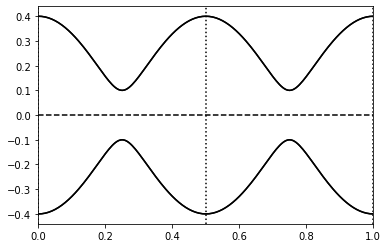

In [4]:
from pysktb import *
a=Atom("a",[0,0,0])
a.set_orbitals(["s","px"])
atoms=[a]
lattice=Lattice([[1,0,0],[0,10,0],[0,0,10]],1)
sk={"a":{"e_p":0
         ,"e_s":0},
    "aa":{"V_sss":-.2,
          "V_sps":-.05,
          "V_pps":0.2}}
bond={"aa":{"NN":1.2}}

s=Structure(lattice,atoms,bond_cut=bond)

ham1=Hamiltonian(s,sk)

path=[[0.5, 0.0, 0.0], [0.0, 0.0, 0.0], [-.5, 0.0, -0.0]]

k_path, k_dist,k_pts=ham1.get_kpts(path,100)
eigs_k = []


evals=ham1.solve_kpath(k_path)

fig,ax=plt.subplots()
for i in evals:ax.plot(k_dist,i,c="k")
for i in k_pts:ax.axvline(i,c="k",ls=":")
ax.axhline(0,c="k",ls="--")
ax.set_xlim(k_pts.min(),k_pts.max())
plt.savefig("sp-chain.png")
plt.show()


### We can project it on to each orbitals
Hameltonian always counts for spin and hence we have 4x4 system even though we have 2 orbitals (this is to save time on the fly for SOC)

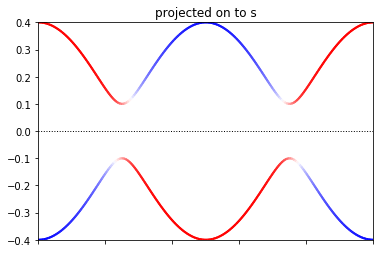

In [5]:
evals,vecs=ham1.solve_kpath(k_path, eig_vectors=True)
fig,ax=plt.subplots()
ham1.plot_kproj(evals,vecs,k_dist,index=[0,1],ax=ax)
ax.set_xticklabels([""])
ax.set_title("projected on to s")
plt.savefig("sp-chain-proj.png")
plt.show()

# Graphene

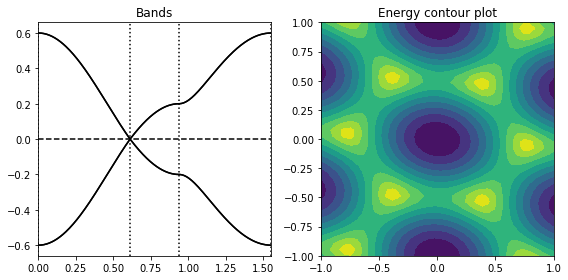

In [8]:
a=Atom("C",[1./3.,1./3.,0])
b=Atom("C",[2./3.,2./3.,0])
atoms=[a,b]
for i in atoms:
    i.set_orbitals(["pz"])
# lattice(plat,alat)
lattice=Lattice([[1.0,0.0,0],[0.5,np.sqrt(3.0)/2.0,0],[0,0,10]],1)

# SK interaction values 
interactions={"C":{"e_p":0}
    ,"CC":{"V_ppp":.2}}

bond={"CC":{"NN":.8}}

# defining the structure class
s=Structure(lattice,atoms,bond_cut=bond)

# defining the hameltonian with interactions
ham=Hamiltonian(s,interactions)


# solve it along a path

path=[[0.,0.,0],[2./3.,1./3.,0],[.5,.5,0],[0.,0.,0]]
k_path, k_dist,k_pts=ham.get_kpts(path,100)

evals=ham.solve_kpath(k_path)


fig,ax=plt.subplots(1,2,figsize=(8,4))
for i in evals:ax[0].plot(k_dist,i,c="k")
for i in k_pts:ax[0].axvline(i,c="k",ls=":")
ax[0].axhline(0,c="k",ls="--")
ax[0].set_xlim(k_pts.min(),k_pts.max())
ax[0].set_title("Bands")

e=[]
for i in np.linspace(-1,1,40):
    for j in np.linspace(-1,1,40):
        k=ham.k_red2cart([i,j,0])
        evals=ham.solve_k(k)
        e.append(evals)
ax[1].contourf(np.linspace(-1,1,40),np.linspace(-1,1,40),
               np.array(e).reshape(40,40,-1)[:,:,0],10)
ax[1].set_title("Energy contour plot")
plt.tight_layout()
plt.savefig("graphene.png")
plt.show()

## Interfaceing cif file structure using pymatgen with ham
### need to write helper modules to use pymatgen/ase to make it easy

Also shown how to include SOC

In [3]:
import pymatgen as p
C=p.Structure.from_file("c.cif")
# make a finite nano ribbon
C_copy=C.copy()
C_copy.make_supercell([[1,0,0],[0,1,0],[0,0,1]])
[zigzag,bearded]=p.core.surface.SlabGenerator(C_copy,miller_index=[1,0,0]
                             ,min_slab_size=18,
                             min_vacuum_size=3).get_slabs()#[1]#.to("cif","finite.cif"))

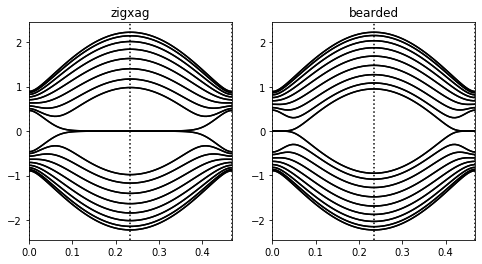

In [4]:
def bands_from_pymatgen(struc,ax):
    atoms=[]
    for i in struc:
        atoms.append(Atom(i.species_string,i.frac_coords))
    for i in atoms:
        i.set_orbitals(["pz"])

    d=0
    lattice=Lattice(struc.lattice.matrix,1)
    interactions={"C":{"e_p":0}
        ,"CC":{"V_ppp":-.9,"V_pps":1.2}}


    nn=np.unique(np.sort(struc.distance_matrix.flatten()))[1]
    bond={"CC":{"NN":nn+.5}}


    s=Structure(lattice,atoms,bond_cut=bond)
    ham=Hamiltonian(s,interactions)

    path=[[0.,0.,0],[0.5,0,0],[1,0,0]]
    k_path, k_dist,k_pts=ham.get_kpts(path,40)

    eigs_k = []
    evals=ham.solve_kpath(k_path)

    for i in evals:ax.plot(k_dist,i,c="k")
    for i in k_pts:ax.axvline(i,c="k",ls=":")
    ax.set_xlim(k_pts.min(),k_pts.max())

fig,ax=plt.subplots(1,2,figsize=(8,4))
bands_from_pymatgen(zigzag,ax[0])
bands_from_pymatgen(bearded,ax[1])
title=["zigxag","bearded"]
for j,i in enumerate(ax):i.set_title(title[j])
plt.savefig("graphene-Edge-states.png")

In [6]:

import pymatgen as p
C=p.Structure.from_file("c.cif")

atoms=[]

# Need to consider px-py-pz for SOC effect as of now. 
for i in C:
    atoms.append(Atom(i.species_string,i.frac_coords))
for i in atoms:
    i.set_orbitals(["px","py","pz"])

#set py,pz levels different to not deentangle from pz of our system and include SOC
d=3
lattice=Lattice(C.lattice.matrix,1)
interactions={"C":{"e_p":[-d,-d,d],"lambda":1.5}
    ,"CC":{"V_ppp":-.2,"V_pps":1.2}}

# minimum distance neibghor
nn=np.unique(np.sort(C.distance_matrix.flatten()))[1]
bond={"CC":{"NN":nn+.5}}


s=Structure(lattice,atoms,bond_cut=bond)

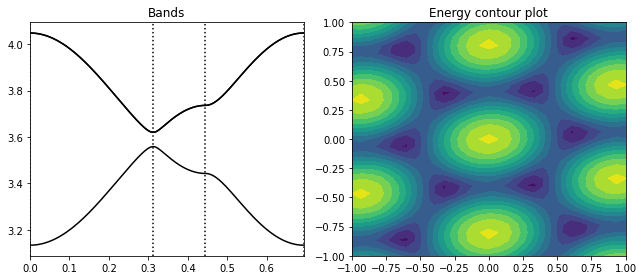

In [71]:

# defining the hameltonian with interactions
ham=Hamiltonian(s,interactions)


# solve it along a path

path=[[0.,0.,0],[1./3.,-2./3.,0],[0.5,-0.5,0],[0.,0.,0]]
k_path, k_dist,k_pts=ham.get_kpts(path,100)

evals=ham.solve_kpath(k_path)

#plot just pz bands

fig,ax=plt.subplots(1,2,figsize=(9,4))
for i in evals[-3:]:ax[0].plot(k_dist,i,c="k")
for i in k_pts:ax[0].axvline(i,c="k",ls=":")
#ax[0].axhline(0,c="k",ls="--")
ax[0].set_xlim(k_pts.min(),k_pts.max())
ax[0].set_title("Bands")

e=[]
nk=31
for i in np.linspace(-.5,.5,nk):
    for j in np.linspace(-.5,.5,nk):
        k=ham.k_red2cart([i,j,0])
        k=ham.k_red2cart([i,j,0])
        evals=ham.solve_k(k)
        e.append(evals)
ax[1].contourf(np.linspace(-1,1,nk),np.linspace(-1,1,nk),
               np.array(e).reshape(nk,nk,-1)[:,:,-1],10)
ax[1].set_title("Energy contour plot")
plt.tight_layout()
plt.show()

# buckled Sb Monolayer
## arXiv:1912.03755 

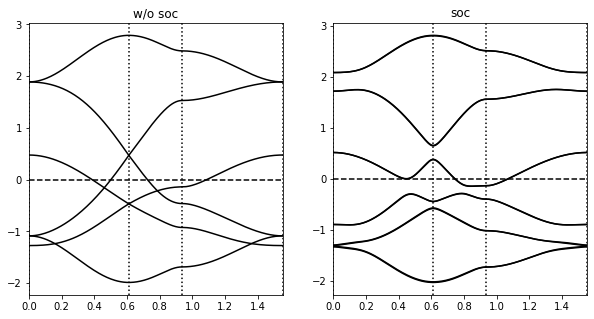

In [3]:
theta=np.deg2rad(1.2)
h=np.sin(theta)*np.cos(theta)
a=Atom("a",[1./3.,1./3.,2+h/10])
a.set_orbitals(["px","py","pz"])
b=Atom("b",[2./3.,2./3.,2-h/10])
b.set_orbitals(["px","py","pz"])
atoms=[a,b]
# lattice(plat,alat)
lattice=Lattice([[1.0,0.0,0],[0.5,np.sqrt(3.0)/2.0,0],[0,0,10/np.cos(theta)]],np.cos(theta))

# SK interaction values 
d=0.4
interactions={"a":{"e_p":[d,d,-d],"lambda":0.19}
    ,"b":{"e_p":[d,d,-d],"lambda":0.2},
    "ab":{"V_ppp":-0.3,"V_pps":1.3},
    "bb":{"V_ppp":0,"V_pps":0},
    "aa":{"V_ppp":0,"V_pps":0.}}

#NN distance for each pair
bond={"ab":{"NN":1},
      "aa":{"NN":0},
      "bb":{"NN":0}}

# defining the structure class
s=Structure(lattice,atoms,bond_cut=bond)

# defining the hameltonian with interactions
ham=Hamiltonian(s,interactions)


# solve it along a path

path=[[0.,0.,0],[2./3.,1./3.,0],[.5,.5,0],[0.,0.,0]]
k_path, k_dist,k_pts=ham.get_kpts(path,100)

evals_soc = []
evals = []
for kpt in k_path:
        H = ham.get_ham(np.array(kpt))
        eigs = np.linalg.eigvalsh(H)
        evals_soc.append(eigs)
        
        H = ham.get_ham(np.array(kpt),l_soc=False)
        eigs = np.linalg.eigvalsh(H)
        evals.append(eigs)

evals = np.array(evals).T
evals_soc = np.array(evals_soc).T

fig,ax=plt.subplots(1,2,figsize=(10,5))
for axis in range(2):
    if axis==0:
        e=evals;title="w/o soc"
    else:e=evals_soc;title="soc"
    for i in e:ax[axis].plot(k_dist,i,c="k")
    for i in k_pts:ax[axis].axvline(i,c="k",ls=":")
    ax[axis].axhline(0,c="k",ls="--")
    ax[axis].set_xlim(k_pts.min(),k_pts.max())
    ax[axis].set_title(title)
plt.show()

### SOC spin split in low buckled Group -V system 
#### projected on to Sz component 

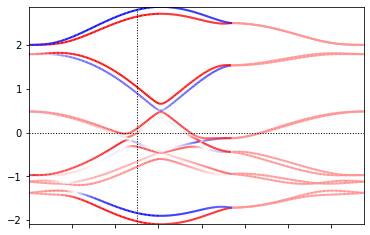

In [48]:
theta=np.deg2rad(1.2)
h=np.sin(theta)*np.cos(theta)
a=Atom("a",[1./3.,1./3.,2+h/10])
a.set_orbitals(["px","py","pz"])
b=Atom("b",[2./3.,2./3.,2-h/10])
b.set_orbitals(["px","py","pz"])
atoms=[a,b]
# lattice(plat,alat)
lattice=Lattice([[1.0,0.0,0],[0.5,np.sqrt(3.0)/2.0,0],[0,0,10/np.cos(theta)]],np.cos(theta))

# SK interaction values 
d=0.4
interactions={"a":{"e_p":[d,d,-d],"lambda":0.03}
    ,"b":{"e_p":[d,d,-d],"lambda":0.2},
    "ab":{"V_ppp":-0.3,"V_pps":1.3},
    "bb":{"V_ppp":0,"V_pps":0},
    "aa":{"V_ppp":0,"V_pps":0.}}

#NN distance for each pair
bond={"ab":{"NN":1},
      "aa":{"NN":0},
      "bb":{"NN":0}}

# defining the structure class
s=Structure(lattice,atoms,bond_cut=bond)

# defining the hameltonian with interactions
ham=Hamiltonian(s,interactions)

path=[[0.,0.,0],[2./3.,1./3.,0],[.5,.5,0],[0.,0.,0]]
k_path, k_dist,k_pts=ham.get_kpts(path,100)

evals,vecs=ham.solve_kpath(k_path, eig_vectors=True)
fig,ax=plt.subplots()
ham1.plot_kproj(evals,vecs,k_dist,index=np.arange(11)[::2],ax=ax,cmap="bwr")
ax.set_xticklabels([""])
plt.show()

## Group V -  Fully buckled case HOTI
### Higher Order Topological Insulators

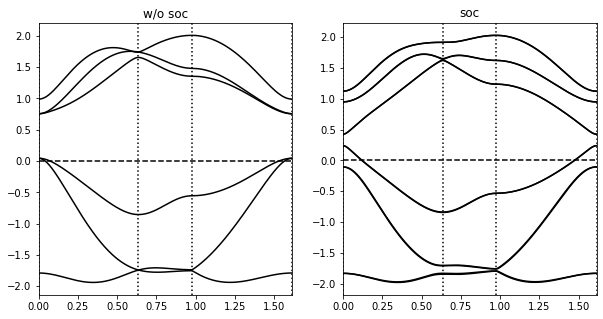

In [72]:
theta=np.deg2rad(16)
h=np.sin(theta)*np.cos(theta)
a=Atom("a",[1./3.,1./3.,2+h/10])
a.set_orbitals(["px","py","pz"])
b=Atom("b",[2./3.,2./3.,2-h/10])
b.set_orbitals(["px","py","pz"])
atoms=[a,b]
# lattice(plat,alat)
lattice=Lattice([[1.0,0.0,0],[0.5,np.sqrt(3.0)/2.0,0],[0,0,10/np.cos(theta)]],np.cos(theta))

# SK interaction values 
d=0.4
interactions={"a":{"e_p":[d,d,-d],"lambda":0.19}
    ,"b":{"e_p":[d,d,-d],"lambda":0.2},
    "ab":{"V_ppp":-0.3,"V_pps":1.3},
    "bb":{"V_ppp":0,"V_pps":0},
    "aa":{"V_ppp":0,"V_pps":0.}}

#NN distance for each pair
bond={"ab":{"NN":1},
      "aa":{"NN":0},
      "bb":{"NN":0}}

# defining the structure class
s=Structure(lattice,atoms,bond_cut=bond)

# defining the hameltonian with interactions
ham=Hamiltonian(s,interactions)


# solve it along a path

path=[[0.,0.,0],[2./3.,1./3.,0],[.5,.5,0],[0.,0.,0]]
k_path, k_dist,k_pts=ham.get_kpts(path,100)

evals_soc = []
evals = []
for kpt in k_path:
        H = ham.get_ham(np.array(kpt))
        eigs = np.linalg.eigvalsh(H)
        evals_soc.append(eigs)
        
        H = ham.get_ham(np.array(kpt),l_soc=False)
        eigs = np.linalg.eigvalsh(H)
        evals.append(eigs)

evals = np.array(evals).T
evals_soc = np.array(evals_soc).T

fig,ax=plt.subplots(1,2,figsize=(10,5))
for axis in range(2):
    if axis==0:
        e=evals;title="w/o soc"
    else:e=evals_soc;title="soc"
    for i in e:ax[axis].plot(k_dist,i,c="k")
    for i in k_pts:ax[axis].axvline(i,c="k",ls=":")
    ax[axis].axhline(0,c="k",ls="--")
    ax[axis].set_xlim(k_pts.min(),k_pts.max())
    ax[axis].set_title(title)
plt.show()